In [1]:
# 平均二乗誤差で学習
# sigmoidをモデルの出力に含める

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    exp='003'
    wandb=True
    resume = None  # [None, 'auto', 'always']
    competition='PPPM'
    debug=False  # False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [3]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Thu Jun  2 10:46:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [4]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
CPU times: user 35.3 ms, sys: 27.9 ms, total: 63.2 ms
Wall time: 1.37 s


In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [6]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    !pip install -q wandb
    import wandb

    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        with open('/content/drive/MyDrive/kaggle/wandb') as f:
           wandb_api_key = f.readline().rstrip('\n')
        wandb.login(key=wandb_api_key)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                     name=CFG.exp,
                     config=class2dict(CFG),
                    #  group=CFG.exp,
                     job_type="train",
                     resume=CFG.resume,  # 'auto'
                     anonymous=anony)

wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Library

In [7]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [9]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [10]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [11]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

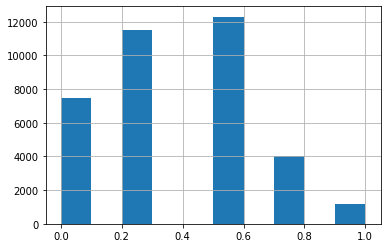

In [12]:
train['score'].hist()

In [13]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [14]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [15]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [16]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [17]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [18]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [19]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [20]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [21]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
            loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))  # "Found dtype Float but expected Half" 対策でautocast内でloss計算
            if CFG.gradient_accumulation_steps > 1:
                loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())  # y_preds.sigmoid().to('cpu').numpy()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [22]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.MSELoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    if wandb.run.resumed:
        checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['model'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        # amp.load_state_dict(checkpoint['amp'])
        epoch = checkpoint['epoeh'] + 1  # 保存時のエポックが読み出されるので+1
        best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        torch.save({'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                    # 'amp': amp.state_dict(),
                    'epoch': epoch,
                    'best_score': best_score},
                    checkpoint_path)
        # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [23]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'oof.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            torch.save({'fold': fold,
                        'oof_df': oof_df},
                        OUTPUT_DIR + 'oof.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

========== fold: 0 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

Epoch: [1][0/1693] Elapsed 0m 1s (remain 43m 28s) Loss: 0.0985(0.0985) Grad: 94902.9531  LR: 0.00002000  
Epoch: [1][100/1693] Elapsed 1m 36s (remain 25m 23s) Loss: 0.0406(0.0638) Grad: 40386.6680  LR: 0.00001999  
Epoch: [1][200/1693] Elapsed 3m 11s (remain 23m 44s) Loss: 0.0376(0.0526) Grad: 50404.4375  LR: 0.00001996  
Epoch: [1][300/1693] Elapsed 4m 46s (remain 22m 5s) Loss: 0.0244(0.0461) Grad: 48437.4375  LR: 0.00001990  
Epoch: [1][400/1693] Elapsed 6m 21s (remain 20m 28s) Loss: 0.0402(0.0427) Grad: 54711.4922  LR: 0.00001983  
Epoch: [1][500/1693] Elapsed 7m 56s (remain 18m 52s) Loss: 0.0227(0.0395) Grad: 41943.3594  LR: 0.00001973  
Epoch: [1][600/1693] Elapsed 9m 30s (remain 17m 17s) Loss: 0.0176(0.0373) Grad: 28281.0508  LR: 0.00001961  
Epoch: [1][700/1693] Elapsed 11m 5s (remain 15m 42s) Loss: 0.0312(0.0356) Grad: 44231.5000  LR: 0.00001948  
Epoch: [1][800/1693] Elapsed 12m 40s (remain 14m 6s) Loss: 0.0302(0.0344) Grad: 68605.9609  LR: 0.00001932  
Epoch: [1][900/1693] El

Epoch 1 - avg_train_loss: 0.0280  avg_val_loss: 0.0213  time: 1777s
Epoch 1 - Score: 0.8301


EVAL: [586/587] Elapsed 2m 51s (remain 0m 0s) Loss: 0.0091(0.0213) 


Epoch 1 - Save Best Score: 0.8301 Model


Epoch: [2][0/1693] Elapsed 0m 1s (remain 35m 0s) Loss: 0.0178(0.0178) Grad: 30268.4805  LR: 0.00001707  
Epoch: [2][100/1693] Elapsed 1m 37s (remain 25m 41s) Loss: 0.0218(0.0154) Grad: 55424.0547  LR: 0.00001673  
Epoch: [2][200/1693] Elapsed 3m 13s (remain 23m 53s) Loss: 0.0043(0.0157) Grad: 15583.1924  LR: 0.00001638  
Epoch: [2][300/1693] Elapsed 4m 48s (remain 22m 12s) Loss: 0.0092(0.0151) Grad: 39268.2266  LR: 0.00001602  
Epoch: [2][400/1693] Elapsed 6m 22s (remain 20m 33s) Loss: 0.0120(0.0154) Grad: 40556.5820  LR: 0.00001564  
Epoch: [2][500/1693] Elapsed 7m 57s (remain 18m 56s) Loss: 0.0116(0.0153) Grad: 28542.9043  LR: 0.00001525  
Epoch: [2][600/1693] Elapsed 9m 32s (remain 17m 20s) Loss: 0.0069(0.0154) Grad: 26729.6504  LR: 0.00001485  
Epoch: [2][700/1693] Elapsed 11m 7s (remain 15m 44s) Loss: 0.0239(0.0156) Grad: 52403.4180  LR: 0.00001444  
Epoch: [2][800/1693] Elapsed 12m 42s (remain 14m 9s) Loss: 0.0090(0.0155) Grad: 16487.5449  LR: 0.00001402  
Epoch: [2][900/1693] El

Epoch 2 - avg_train_loss: 0.0154  avg_val_loss: 0.0216  time: 1781s
Epoch 2 - Score: 0.8334


EVAL: [586/587] Elapsed 2m 51s (remain 0m 0s) Loss: 0.0110(0.0216) 


Epoch 2 - Save Best Score: 0.8334 Model


Epoch: [3][0/1693] Elapsed 0m 1s (remain 37m 5s) Loss: 0.0047(0.0047) Grad: 13535.6494  LR: 0.00001000  
Epoch: [3][100/1693] Elapsed 1m 38s (remain 25m 46s) Loss: 0.0044(0.0100) Grad: 14099.7139  LR: 0.00000953  
Epoch: [3][200/1693] Elapsed 3m 12s (remain 23m 52s) Loss: 0.0154(0.0101) Grad: 29940.3828  LR: 0.00000907  
Epoch: [3][300/1693] Elapsed 4m 47s (remain 22m 11s) Loss: 0.0084(0.0102) Grad: 20069.7695  LR: 0.00000861  
Epoch: [3][400/1693] Elapsed 6m 22s (remain 20m 33s) Loss: 0.0094(0.0104) Grad: 16982.6035  LR: 0.00000815  
Epoch: [3][500/1693] Elapsed 7m 57s (remain 18m 56s) Loss: 0.0305(0.0103) Grad: 115151.3516  LR: 0.00000770  
Epoch: [3][600/1693] Elapsed 9m 32s (remain 17m 20s) Loss: 0.0149(0.0104) Grad: 29534.3633  LR: 0.00000725  
Epoch: [3][700/1693] Elapsed 11m 7s (remain 15m 44s) Loss: 0.0108(0.0106) Grad: 26065.5918  LR: 0.00000681  
Epoch: [3][800/1693] Elapsed 12m 42s (remain 14m 8s) Loss: 0.0135(0.0107) Grad: 28834.0508  LR: 0.00000637  
Epoch: [3][900/1693] E

Epoch 3 - avg_train_loss: 0.0104  avg_val_loss: 0.0217  time: 1781s
Epoch 3 - Score: 0.8324


EVAL: [586/587] Elapsed 2m 51s (remain 0m 0s) Loss: 0.0070(0.0217) 
Epoch: [4][0/1693] Elapsed 0m 1s (remain 34m 26s) Loss: 0.0012(0.0012) Grad: 5782.2402  LR: 0.00000293  
Epoch: [4][100/1693] Elapsed 1m 37s (remain 25m 34s) Loss: 0.0086(0.0077) Grad: 17354.8477  LR: 0.00000261  
Epoch: [4][200/1693] Elapsed 3m 12s (remain 23m 47s) Loss: 0.0115(0.0080) Grad: 30126.3203  LR: 0.00000230  
Epoch: [4][300/1693] Elapsed 4m 47s (remain 22m 8s) Loss: 0.0022(0.0081) Grad: 10736.6768  LR: 0.00000202  
Epoch: [4][400/1693] Elapsed 6m 22s (remain 20m 32s) Loss: 0.0114(0.0080) Grad: 29732.5527  LR: 0.00000175  
Epoch: [4][500/1693] Elapsed 7m 57s (remain 18m 55s) Loss: 0.0226(0.0080) Grad: 40291.3789  LR: 0.00000149  
Epoch: [4][600/1693] Elapsed 9m 32s (remain 17m 19s) Loss: 0.0055(0.0081) Grad: 19698.6562  LR: 0.00000126  
Epoch: [4][700/1693] Elapsed 11m 7s (remain 15m 43s) Loss: 0.0043(0.0081) Grad: 12941.7178  LR: 0.00000104  
Epoch: [4][800/1693] Elapsed 12m 41s (remain 14m 8s) Loss: 0.0033

Epoch 4 - avg_train_loss: 0.0080  avg_val_loss: 0.0213  time: 1779s
Epoch 4 - Score: 0.8340


EVAL: [586/587] Elapsed 2m 50s (remain 0m 0s) Loss: 0.0099(0.0213) 


Epoch 4 - Save Best Score: 0.8340 Model
========== fold: 0 result ==========
Score: 0.8340
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exact

Epoch: [1][0/1725] Elapsed 0m 1s (remain 43m 55s) Loss: 0.1219(0.1219) Grad: 131120.2812  LR: 0.00002000  
Epoch: [1][100/1725] Elapsed 1m 37s (remain 26m 6s) Loss: 0.0455(0.0645) Grad: 27298.1172  LR: 0.00001999  
Epoch: [1][200/1725] Elapsed 3m 12s (remain 24m 18s) Loss: 0.0202(0.0514) Grad: 11563.9277  LR: 0.00001996  
Epoch: [1][300/1725] Elapsed 4m 47s (remain 22m 38s) Loss: 0.0202(0.0452) Grad: 20631.1250  LR: 0.00001991  
Epoch: [1][400/1725] Elapsed 6m 22s (remain 21m 1s) Loss: 0.0362(0.0416) Grad: 21994.1289  LR: 0.00001983  
Epoch: [1][500/1725] Elapsed 7m 56s (remain 19m 25s) Loss: 0.0312(0.0390) Grad: 280169.3438  LR: 0.00001974  
Epoch: [1][600/1725] Elapsed 9m 31s (remain 17m 49s) Loss: 0.0285(0.0381) Grad: 15888.1572  LR: 0.00001963  
Epoch: [1][700/1725] Elapsed 11m 6s (remain 16m 13s) Loss: 0.0184(0.0364) Grad: 7599.5884  LR: 0.00001950  
Epoch: [1][800/1725] Elapsed 12m 41s (remain 14m 38s) Loss: 0.0336(0.0351) Grad: 9134.0996  LR: 0.00001934  
Epoch: [1][900/1725] El

Epoch 1 - avg_train_loss: 0.0286  avg_val_loss: 0.0234  time: 1801s
Epoch 1 - Score: 0.8085


EVAL: [553/554] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0126(0.0234) 


Epoch 1 - Save Best Score: 0.8085 Model


Epoch: [2][0/1725] Elapsed 0m 1s (remain 42m 11s) Loss: 0.0084(0.0084) Grad: 14874.4434  LR: 0.00001707  
Epoch: [2][100/1725] Elapsed 1m 38s (remain 26m 16s) Loss: 0.0061(0.0151) Grad: 15768.9023  LR: 0.00001674  
Epoch: [2][200/1725] Elapsed 3m 13s (remain 24m 26s) Loss: 0.0288(0.0146) Grad: 49323.0820  LR: 0.00001640  
Epoch: [2][300/1725] Elapsed 4m 48s (remain 22m 44s) Loss: 0.0194(0.0143) Grad: 26525.8281  LR: 0.00001604  
Epoch: [2][400/1725] Elapsed 6m 23s (remain 21m 6s) Loss: 0.0150(0.0141) Grad: 82876.7891  LR: 0.00001567  
Epoch: [2][500/1725] Elapsed 7m 58s (remain 19m 29s) Loss: 0.0265(0.0141) Grad: 57369.8398  LR: 0.00001529  
Epoch: [2][600/1725] Elapsed 9m 33s (remain 17m 52s) Loss: 0.0173(0.0139) Grad: 34843.0469  LR: 0.00001490  
Epoch: [2][700/1725] Elapsed 11m 9s (remain 16m 17s) Loss: 0.0178(0.0137) Grad: 52486.2812  LR: 0.00001450  
Epoch: [2][800/1725] Elapsed 12m 44s (remain 14m 41s) Loss: 0.0165(0.0136) Grad: 27638.4141  LR: 0.00001409  
Epoch: [2][900/1725] E

Epoch 2 - avg_train_loss: 0.0132  avg_val_loss: 0.0242  time: 1805s
Epoch 2 - Score: 0.8169


EVAL: [553/554] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0016(0.0242) 


Epoch 2 - Save Best Score: 0.8169 Model


Epoch: [3][0/1725] Elapsed 0m 1s (remain 48m 56s) Loss: 0.0297(0.0297) Grad: 23249.9355  LR: 0.00001000  
Epoch: [3][100/1725] Elapsed 1m 36s (remain 25m 57s) Loss: 0.0107(0.0096) Grad: 16204.6924  LR: 0.00000955  
Epoch: [3][200/1725] Elapsed 3m 11s (remain 24m 15s) Loss: 0.0171(0.0099) Grad: 23297.0391  LR: 0.00000909  
Epoch: [3][300/1725] Elapsed 4m 47s (remain 22m 38s) Loss: 0.0162(0.0100) Grad: 23927.4395  LR: 0.00000864  
Epoch: [3][400/1725] Elapsed 6m 22s (remain 21m 1s) Loss: 0.0032(0.0100) Grad: 14232.3643  LR: 0.00000819  
Epoch: [3][500/1725] Elapsed 7m 57s (remain 19m 25s) Loss: 0.0100(0.0100) Grad: 20167.0840  LR: 0.00000775  
Epoch: [3][600/1725] Elapsed 9m 32s (remain 17m 50s) Loss: 0.0107(0.0100) Grad: 23525.0000  LR: 0.00000731  
Epoch: [3][700/1725] Elapsed 11m 7s (remain 16m 15s) Loss: 0.0204(0.0099) Grad: 34773.4180  LR: 0.00000687  
Epoch: [3][800/1725] Elapsed 12m 42s (remain 14m 39s) Loss: 0.0070(0.0098) Grad: 10132.5293  LR: 0.00000644  
Epoch: [3][900/1725] E

Epoch 3 - avg_train_loss: 0.0096  avg_val_loss: 0.0230  time: 1803s
Epoch 3 - Score: 0.8221


EVAL: [553/554] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0012(0.0230) 


Epoch 3 - Save Best Score: 0.8221 Model


Epoch: [4][0/1725] Elapsed 0m 1s (remain 37m 15s) Loss: 0.0069(0.0069) Grad: 20859.9844  LR: 0.00000293  
Epoch: [4][100/1725] Elapsed 1m 36s (remain 25m 46s) Loss: 0.0091(0.0083) Grad: 22409.3789  LR: 0.00000262  
Epoch: [4][200/1725] Elapsed 3m 11s (remain 24m 10s) Loss: 0.0081(0.0081) Grad: 15166.2676  LR: 0.00000232  
Epoch: [4][300/1725] Elapsed 4m 46s (remain 22m 36s) Loss: 0.0061(0.0080) Grad: 21107.9199  LR: 0.00000204  
Epoch: [4][400/1725] Elapsed 6m 21s (remain 20m 59s) Loss: 0.0027(0.0079) Grad: 14652.6602  LR: 0.00000177  
Epoch: [4][500/1725] Elapsed 7m 56s (remain 19m 24s) Loss: 0.0054(0.0078) Grad: 13037.2559  LR: 0.00000152  
Epoch: [4][600/1725] Elapsed 9m 32s (remain 17m 49s) Loss: 0.0071(0.0078) Grad: 15375.9873  LR: 0.00000129  
Epoch: [4][700/1725] Elapsed 11m 7s (remain 16m 14s) Loss: 0.0073(0.0077) Grad: 16986.5996  LR: 0.00000107  
Epoch: [4][800/1725] Elapsed 12m 42s (remain 14m 39s) Loss: 0.0032(0.0076) Grad: 18097.3438  LR: 0.00000088  
Epoch: [4][900/1725] 

Epoch 4 - avg_train_loss: 0.0076  avg_val_loss: 0.0231  time: 1804s
Epoch 4 - Score: 0.8199


EVAL: [553/554] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0018(0.0231) 


========== fold: 1 result ==========
Score: 0.8221
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1741] Elapsed 0m 1s (remain 44m 21s) Loss: 0.0500(0.0500) Grad: 69166.0625  LR: 0.00002000  
Epoch: [1][100/1741] Elapsed 1m 36s (remain 26m 8s) Loss: 0.0369(0.0656) Grad: 24331.3398  LR: 0.00001999  
Epoch: [1][200/1741] Elapsed 3m 11s (remain 24m 29s) Loss: 0.0370(0.0533) Grad: 53579.3164  LR: 0.00001996  
Epoch: [1][300/1741] Elapsed 4m 46s (remain 22m 52s) Loss: 0.0263(0.0466) Grad: 53435.3320  LR: 0.00001991  
Epoch: [1][400/1741] Elapsed 6m 22s (remain 21m 17s) Loss: 0.0252(0.0426) Grad: 48008.5078  LR: 0.00001984  
Epoch: [1][500/1741] Elapsed 7m 57s (remain 19m 41s) Loss: 0.0191(0.0400) Grad: 148419.4688  LR: 0.00001975  
Epoch: [1][600/1741] Elapsed 9m 32s (remain 18m 5s) Loss: 0.0276(0.0379) Grad: 18115.1680  LR: 0.00001963  
Epoch: [1][700/1741] Elapsed 11m 7s (remain 16m 30s) Loss: 0.0587(0.0363) Grad: 31290.4375  LR: 0.00001950  
Epoch: [1][800/1741] Elapsed 12m 42s (remain 14m 55s) Loss: 0.0155(0.0349) Grad: 18087.8594  LR: 0.00001935  
Epoch: [1][900/1741] E

Epoch 1 - avg_train_loss: 0.0283  avg_val_loss: 0.0209  time: 1817s
Epoch 1 - Score: 0.8349


EVAL: [538/539] Elapsed 2m 37s (remain 0m 0s) Loss: 0.0202(0.0209) 


Epoch 1 - Save Best Score: 0.8349 Model


Epoch: [2][0/1741] Elapsed 0m 1s (remain 37m 56s) Loss: 0.0096(0.0096) Grad: 18519.7363  LR: 0.00001707  
Epoch: [2][100/1741] Elapsed 1m 38s (remain 26m 31s) Loss: 0.0218(0.0148) Grad: 24110.5371  LR: 0.00001674  
Epoch: [2][200/1741] Elapsed 3m 13s (remain 24m 39s) Loss: 0.0273(0.0147) Grad: 35241.1172  LR: 0.00001640  
Epoch: [2][300/1741] Elapsed 4m 48s (remain 22m 58s) Loss: 0.0240(0.0147) Grad: 31693.0938  LR: 0.00001605  
Epoch: [2][400/1741] Elapsed 6m 23s (remain 21m 20s) Loss: 0.0154(0.0145) Grad: 31079.3301  LR: 0.00001568  
Epoch: [2][500/1741] Elapsed 7m 58s (remain 19m 43s) Loss: 0.0074(0.0147) Grad: 14082.5430  LR: 0.00001531  
Epoch: [2][600/1741] Elapsed 9m 33s (remain 18m 7s) Loss: 0.0128(0.0147) Grad: 19027.5566  LR: 0.00001492  
Epoch: [2][700/1741] Elapsed 11m 8s (remain 16m 32s) Loss: 0.0097(0.0147) Grad: 28744.9199  LR: 0.00001452  
Epoch: [2][800/1741] Elapsed 12m 43s (remain 14m 56s) Loss: 0.0057(0.0146) Grad: 11947.1084  LR: 0.00001412  
Epoch: [2][900/1741] E

Epoch 2 - avg_train_loss: 0.0142  avg_val_loss: 0.0202  time: 1814s
Epoch 2 - Score: 0.8437


EVAL: [538/539] Elapsed 2m 37s (remain 0m 0s) Loss: 0.0164(0.0202) 


Epoch 2 - Save Best Score: 0.8437 Model


Epoch: [3][0/1741] Elapsed 0m 1s (remain 43m 30s) Loss: 0.0124(0.0124) Grad: 15246.0957  LR: 0.00001000  
Epoch: [3][100/1741] Elapsed 1m 37s (remain 26m 28s) Loss: 0.0070(0.0106) Grad: 21203.1562  LR: 0.00000955  
Epoch: [3][200/1741] Elapsed 3m 12s (remain 24m 38s) Loss: 0.0084(0.0096) Grad: 14502.5098  LR: 0.00000910  
Epoch: [3][300/1741] Elapsed 4m 47s (remain 22m 56s) Loss: 0.0185(0.0097) Grad: 34271.0664  LR: 0.00000865  
Epoch: [3][400/1741] Elapsed 6m 22s (remain 21m 18s) Loss: 0.0127(0.0097) Grad: 21593.8770  LR: 0.00000820  
Epoch: [3][500/1741] Elapsed 7m 57s (remain 19m 41s) Loss: 0.0055(0.0098) Grad: 23822.6133  LR: 0.00000776  
Epoch: [3][600/1741] Elapsed 9m 32s (remain 18m 5s) Loss: 0.0169(0.0099) Grad: 21373.8359  LR: 0.00000732  
Epoch: [3][700/1741] Elapsed 11m 7s (remain 16m 29s) Loss: 0.0086(0.0099) Grad: 23498.2852  LR: 0.00000689  
Epoch: [3][800/1741] Elapsed 12m 42s (remain 14m 54s) Loss: 0.0075(0.0099) Grad: 15144.8799  LR: 0.00000647  
Epoch: [3][900/1741] E

Epoch 3 - avg_train_loss: 0.0098  avg_val_loss: 0.0203  time: 1812s
Epoch 3 - Score: 0.8440


EVAL: [538/539] Elapsed 2m 37s (remain 0m 0s) Loss: 0.0173(0.0203) 


Epoch 3 - Save Best Score: 0.8440 Model


Epoch: [4][0/1741] Elapsed 0m 1s (remain 43m 5s) Loss: 0.0118(0.0118) Grad: 26394.9941  LR: 0.00000293  
Epoch: [4][100/1741] Elapsed 1m 37s (remain 26m 25s) Loss: 0.0113(0.0080) Grad: 29451.8887  LR: 0.00000262  
Epoch: [4][200/1741] Elapsed 3m 12s (remain 24m 36s) Loss: 0.0084(0.0078) Grad: 12595.7227  LR: 0.00000232  
Epoch: [4][300/1741] Elapsed 4m 47s (remain 22m 55s) Loss: 0.0060(0.0078) Grad: 17265.9785  LR: 0.00000204  
Epoch: [4][400/1741] Elapsed 6m 22s (remain 21m 18s) Loss: 0.0074(0.0079) Grad: 15565.0674  LR: 0.00000177  
Epoch: [4][500/1741] Elapsed 7m 57s (remain 19m 41s) Loss: 0.0103(0.0080) Grad: 21681.7480  LR: 0.00000153  
Epoch: [4][600/1741] Elapsed 9m 32s (remain 18m 6s) Loss: 0.0040(0.0079) Grad: 15085.5889  LR: 0.00000130  
Epoch: [4][700/1741] Elapsed 11m 7s (remain 16m 30s) Loss: 0.0059(0.0078) Grad: 11825.7100  LR: 0.00000108  
Epoch: [4][800/1741] Elapsed 12m 42s (remain 14m 54s) Loss: 0.0106(0.0078) Grad: 61970.3516  LR: 0.00000089  
Epoch: [4][900/1741] El

Epoch 4 - avg_train_loss: 0.0077  avg_val_loss: 0.0208  time: 1814s
Epoch 4 - Score: 0.8422


EVAL: [538/539] Elapsed 2m 37s (remain 0m 0s) Loss: 0.0172(0.0208) 


========== fold: 2 result ==========
Score: 0.8440
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1678] Elapsed 0m 1s (remain 40m 28s) Loss: 0.1204(0.1204) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1678] Elapsed 1m 37s (remain 25m 23s) Loss: 0.0436(0.0638) Grad: 27222.9336  LR: 0.00001999  
Epoch: [1][200/1678] Elapsed 3m 12s (remain 23m 35s) Loss: 0.0520(0.0510) Grad: 47972.0703  LR: 0.00001996  
Epoch: [1][300/1678] Elapsed 4m 47s (remain 21m 56s) Loss: 0.0181(0.0445) Grad: 11781.5605  LR: 0.00001990  
Epoch: [1][400/1678] Elapsed 6m 22s (remain 20m 19s) Loss: 0.0314(0.0400) Grad: 22740.2207  LR: 0.00001982  
Epoch: [1][500/1678] Elapsed 7m 58s (remain 18m 43s) Loss: 0.0169(0.0378) Grad: 14159.8896  LR: 0.00001973  
Epoch: [1][600/1678] Elapsed 9m 33s (remain 17m 7s) Loss: 0.0242(0.0358) Grad: 25465.1465  LR: 0.00001961  
Epoch: [1][700/1678] Elapsed 11m 8s (remain 15m 31s) Loss: 0.0240(0.0343) Grad: 41508.3828  LR: 0.00001947  
Epoch: [1][800/1678] Elapsed 12m 43s (remain 13m 56s) Loss: 0.0123(0.0328) Grad: 23060.8184  LR: 0.00001931  
Epoch: [1][900/1678] Elapsed 

Epoch 1 - avg_train_loss: 0.0272  avg_val_loss: 0.0238  time: 1777s
Epoch 1 - Score: 0.8017
Epoch 1 - Save Best Score: 0.8017 Model


Epoch: [2][0/1678] Elapsed 0m 1s (remain 44m 18s) Loss: 0.0053(0.0053) Grad: 11454.4775  LR: 0.00001707  
Epoch: [2][100/1678] Elapsed 1m 38s (remain 25m 42s) Loss: 0.0343(0.0148) Grad: 32658.4297  LR: 0.00001673  
Epoch: [2][200/1678] Elapsed 3m 13s (remain 23m 44s) Loss: 0.0163(0.0146) Grad: 40514.4414  LR: 0.00001638  
Epoch: [2][300/1678] Elapsed 4m 48s (remain 22m 1s) Loss: 0.0086(0.0144) Grad: 21653.6836  LR: 0.00001601  
Epoch: [2][400/1678] Elapsed 6m 23s (remain 20m 22s) Loss: 0.0078(0.0138) Grad: 22932.4277  LR: 0.00001563  
Epoch: [2][500/1678] Elapsed 7m 58s (remain 18m 45s) Loss: 0.0074(0.0140) Grad: 42503.1602  LR: 0.00001523  
Epoch: [2][600/1678] Elapsed 9m 34s (remain 17m 8s) Loss: 0.0151(0.0140) Grad: 51022.9648  LR: 0.00001483  
Epoch: [2][700/1678] Elapsed 11m 9s (remain 15m 32s) Loss: 0.0142(0.0138) Grad: 27736.6289  LR: 0.00001442  
Epoch: [2][800/1678] Elapsed 12m 44s (remain 13m 56s) Loss: 0.0189(0.0138) Grad: 38925.5898  LR: 0.00001399  
Epoch: [2][900/1678] El

Epoch 2 - avg_train_loss: 0.0137  avg_val_loss: 0.0241  time: 1773s
Epoch 2 - Score: 0.8142
Epoch 2 - Save Best Score: 0.8142 Model


Epoch: [3][0/1678] Elapsed 0m 1s (remain 42m 48s) Loss: 0.0087(0.0087) Grad: 18641.9883  LR: 0.00001000  
Epoch: [3][100/1678] Elapsed 1m 37s (remain 25m 29s) Loss: 0.0082(0.0091) Grad: 32422.1465  LR: 0.00000953  
Epoch: [3][200/1678] Elapsed 3m 12s (remain 23m 36s) Loss: 0.0191(0.0093) Grad: 39021.0781  LR: 0.00000906  
Epoch: [3][300/1678] Elapsed 4m 48s (remain 21m 57s) Loss: 0.0052(0.0093) Grad: 16396.6582  LR: 0.00000860  
Epoch: [3][400/1678] Elapsed 6m 23s (remain 20m 20s) Loss: 0.0068(0.0094) Grad: 21851.3340  LR: 0.00000813  
Epoch: [3][500/1678] Elapsed 7m 58s (remain 18m 43s) Loss: 0.0087(0.0095) Grad: 21126.7461  LR: 0.00000768  
Epoch: [3][600/1678] Elapsed 9m 33s (remain 17m 7s) Loss: 0.0110(0.0097) Grad: 16320.8896  LR: 0.00000722  
Epoch: [3][700/1678] Elapsed 11m 8s (remain 15m 31s) Loss: 0.0187(0.0097) Grad: 35085.8203  LR: 0.00000678  
Epoch: [3][800/1678] Elapsed 12m 43s (remain 13m 55s) Loss: 0.0100(0.0097) Grad: 23247.0254  LR: 0.00000634  
Epoch: [3][900/1678] E

Epoch 3 - avg_train_loss: 0.0095  avg_val_loss: 0.0232  time: 1772s
Epoch 3 - Score: 0.8127


Epoch: [4][0/1678] Elapsed 0m 1s (remain 37m 2s) Loss: 0.0090(0.0090) Grad: 16916.8516  LR: 0.00000293  
Epoch: [4][100/1678] Elapsed 1m 37s (remain 25m 19s) Loss: 0.0043(0.0075) Grad: 13267.2539  LR: 0.00000260  
Epoch: [4][200/1678] Elapsed 3m 12s (remain 23m 32s) Loss: 0.0075(0.0073) Grad: 21379.2422  LR: 0.00000230  
Epoch: [4][300/1678] Elapsed 4m 47s (remain 21m 54s) Loss: 0.0085(0.0076) Grad: 18558.0371  LR: 0.00000201  
Epoch: [4][400/1678] Elapsed 6m 22s (remain 20m 17s) Loss: 0.0070(0.0077) Grad: 21422.7012  LR: 0.00000173  
Epoch: [4][500/1678] Elapsed 7m 57s (remain 18m 41s) Loss: 0.0051(0.0077) Grad: 25540.7402  LR: 0.00000148  
Epoch: [4][600/1678] Elapsed 9m 32s (remain 17m 5s) Loss: 0.0066(0.0077) Grad: 15944.0674  LR: 0.00000124  
Epoch: [4][700/1678] Elapsed 11m 7s (remain 15m 29s) Loss: 0.0050(0.0074) Grad: 18412.7402  LR: 0.00000103  
Epoch: [4][800/1678] Elapsed 12m 42s (remain 13m 54s) Loss: 0.0051(0.0074) Grad: 26326.2539  LR: 0.00000083  
Epoch: [4][900/1678] El

Epoch 4 - avg_train_loss: 0.0074  avg_val_loss: 0.0237  time: 1771s
Epoch 4 - Score: 0.8107
========== fold: 3 result ==========
Score: 0.8142
========== CV ==========
Score: 0.8265


[fold0] avg_train_loss,█▄▂▁
[fold0] avg_val_loss,▂▆█▁
[fold0] epoch,▁▃▆█
[fold0] loss,█▄▄▂▄▃▅▃▂▅▁▂▁▂▃▂▂▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▇▅█
[fold1] avg_train_loss,█▃▂▁
[fold1] avg_val_loss,▃█▁▂
[fold1] epoch,▁▃▆█
[fold1] loss,█▄▆▂▅▂▄▃▂▂▂▂▃▂▂▁▁▂▁▂▂▃▂▁▂▂▂▁▂▂▂▂▁▁▁▁▁▁▂▁
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


In [24]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file train.log
100% 2.55k/2.55k [00:02<00:00, 1.12kB/s]
Upload successful: train.log (3KB)
Starting upload for file tokenizer.tar
100% 2.36M/2.36M [00:03<00:00, 695kB/s]
Upload successful: tokenizer.tar (2MB)
Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:04<00:00, 3.53kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file config.pth
100% 2.48k/2.48k [00:04<00:00, 509B/s]
Upload successful: config.pth (2KB)
Starting upload for file checkpoint.pth
100% 4.86G/4.86G [01:44<00:00, 50.0MB/s]
Upload successful: checkpoint.pth (5GB)
Starting upload for file microsoft-deberta-v3-large_fold0_best.pth
100% 1.62G/1.62G [00:43<00:00, 40.1MB/s]
Upload successful: microsoft-deberta-v3-large_fold0_best.pth (2GB)
Starting upload for file oof.pth
100% 7.71M/7.71M [00:04<00:00, 1.95MB/s]
Upload successful: oof.pth (8MB)
Starting upload for file microsoft-deberta-v3-large_fold1_best.pth
100% 1.62G/1.62G [00:40<00:00, 42.8MB/s]
Upload successful: microsoft-